# Data extraction

In [1]:
import pandas as pd
import numpy as np

In [2]:
def loadGameData(initialSeason,finalSeason):
    '''
    loadGameData loads each season of game data into a single table, with columns
    Season, Visitor/Neutral, Home/Neutral, VisitorWin.
    
    Inputs: 
    initialSeason    :    first season (second year of season) to include (int)
    finalSeason      :    last season to include (inclusive) (int)
    
    Outputs:
    dataset          :    pandas dataframe of format described above
    '''
    seasonTables = [] # to store tables from each season
    
    # loop over and download each season's data
    for season in range(initialSeason,finalSeason+1):
        print('Dowloading',season,'season data...')
        table = pd.read_hdf('pyData/games'+str(season)+'.h5','table')
        table = table.reindex(columns=['Season','Visitor/Neutral','Home/Neutral','VisitorWin'])
        seasonStr = str(season)
        table['Season'] = str(season-1)+'-'+seasonStr[2:4] # format season in same way as PCA
        seasonTables.append(table)
        print('##################################')
    
    dataset = pd.concat(seasonTables)
    return dataset

Run <code>loadGameData</code> to extract a table with all the training data, 2000-01 to 2019-20 seasons.

In [3]:
dataset = loadGameData(2001,2020)

Dowloading 2001 season data...
##################################
Dowloading 2002 season data...
##################################
Dowloading 2003 season data...
##################################
Dowloading 2004 season data...
##################################
Dowloading 2005 season data...
##################################
Dowloading 2006 season data...
##################################
Dowloading 2007 season data...
##################################
Dowloading 2008 season data...
##################################
Dowloading 2009 season data...
##################################
Dowloading 2010 season data...
##################################
Dowloading 2011 season data...
##################################
Dowloading 2012 season data...
##################################
Dowloading 2013 season data...
##################################
Dowloading 2014 season data...
##################################
Dowloading 2015 season data...
##################################
Dowloading

In [4]:
def generatePCAVectors(dataFile,seasonToExclude):
    '''
    generataPCAVectors creates the PCA vectors for a subset of the team season-average stat data.
    
    Inputs:
    dataFile - name of the file containing every team's season-average stat data
    seasonToExclude - season to be removed from data set
    
    Outputs:
    statMean - mean of each statistical category included in dataset
    topVectors - top 7 covariance vectors (rows - stat catgory; columns - index in decreasing eigenvalue order)
    '''
    # load data
    dfTeamData = pd.read_hdf(dataFile)
    dfTeamData = dfTeamData[dfTeamData['Season'] != seasonToExclude]
    
    # compute PCA vectors
    teamDataMat = (dfTeamData.loc[:,'FG':'oppPTS']).to_numpy()
    statMean = np.mean(teamDataMat,axis=0) # Mean subtraction
    teamDataZero = teamDataMat - statMean
    N = teamDataZero.shape[0]
    covMat = 1/N*np.dot(teamDataZero.T,teamDataZero) # covariance matrix
    covLam,covVec = np.linalg.eig(covMat) # diagonlize
    inds = np.argsort(covLam) # get indexes of sorted eigenvalues
    topVectors = covVec[:,inds[:-8:-1]] #  covariance eigenvectors of top 7 eigenvalues
    
    # return covariance eigenvectors and means of each stat category
    return statMean,topVectors

In [5]:
statMean,topV = generatePCAVectors('pyData/regSeasonData.h5','2020-21')

In [6]:
def generateInputOutputData(statMean,PCABasis,dataset,statDataFile):
    '''
    generateInputOutputData converts tables of NBA game outcomes into a NumPy matrix giving the PCA components of each
    team and the outcome of the game as a 1 (visitor win) or 0.
    
    Inputs:
    statMean - mean of each team season average statistical category
    PCABasis - matrix whose columns are the PCA basis vectors
    dataset - table (pd.DataFrame) of matchups and game outcomes
    statDataFile - name of file containing team season average stats
    
    Outputs:
    trainingData - matrix where each row is one game, and if n is number of PCA basis vectors, then
                    - first n columns are visiting team's PCA components,
                    - second n columns are home team's PCA components,
                    - final column is 1.0 if visiting team won; 0 otherwise.
    '''
    # convert team stat data to data dictionary
    dfTeamData = pd.read_hdf(statDataFile) # load team stat data
    # convert CHH to CHO for (first year of) season <= 2001
    seasonInts = dfTeamData['Season'].map(lambda x : int(x[0:4]))
    teamAbbrev = dfTeamData['Tm']
    dfTeamData.loc[(seasonInts <= 2001) & (teamAbbrev == 'CHH'),'Tm'] = 'CHO'
    # proceed with data dictionary
    seasonTm = dfTeamData[['Season','Tm']]
    keys = list(seasonTm.itertuples(index=False,name=None)) # keys for stat data dictionary
    teamDataMat = (dfTeamData.loc[:,'FG':'oppPTS']).to_numpy()
    teamDataZero = teamDataMat - statMean
    teamPCA = np.dot(teamDataZero,PCABasis) # values for stat data dictionary
    teamDataDict = dict(zip(keys,teamPCA))
    
    # convert dataset to set of keys for each team and output values (1 if True, 0 otherwise)
    seasonTmVis = dataset[['Season','Visitor/Neutral']]
    x_aKeys = pd.Series(list(seasonTmVis.itertuples(index=False,name=None)),name='x_a')
    seasonTmHom = dataset[['Season','Home/Neutral']]
    x_bKeys = pd.Series(list(seasonTmHom.itertuples(index=False,name=None)),name='x_b')
    y = (dataset['VisitorWin'].map(float)).to_numpy()
    
    
    # convert keys and output values into a single matrix, each row containing each teams PCA components and the outcome 
    x_aPCA = np.stack(x_aKeys.map(teamDataDict))
    x_bPCA = np.stack(x_bKeys.map(teamDataDict))
    trainingData = np.vstack((x_aPCA.T,x_bPCA.T,y)).T

    return trainingData    

In [7]:
trainingData = generateInputOutputData(statMean,topV,dataset,'pyData/regSeasonData.h5')

In [8]:
trainingData.shape

(25674, 15)

# Training

In [9]:
from scipy.integrate import odeint

In [10]:
def sigma(a):
    return 1./(1.+np.exp(-a))

In [11]:
def wVel(w,t,x,y):
    '''
    wVel evaluates velocity dw/dt = -dE/dw of logistic model, where E is error function.
    
    Inputs:
    t - current integration time
    w - array of current values of logistic model parameters
    x - matrix of training data predictors. each row is a different data point;
        assume first column is all ones, remaining columns are values of predictor variables
    y - array of training data outcomes    
        
    Outputs:
    -dE/dw - velocity of parameters (-)
    '''
    sigmaN = sigma(np.dot(x,w))
    dEdw = np.dot(x.T,sigmaN-y)
    return -dEdw

In [12]:
def logisticInt(w0,T,x,y):
    '''
    logisticInt performs gradient descent (dw/dt = -dE/dw) on the logistic regression model.
    
    Inputs:
    w0 - initial set of parameters of the model
    T - total time to integrate for
    x - set of predictor data (each row is a different data point, first column is ones)
    y - set of outcome data
    
    Outputs:
    w - final parameters after integration
    dEdw - gradient of error function at the end of integration
    Et - value of error function as a function of time
    tt - time steps
    '''
    # perform gradient descent
    nSteps = 100
    tt = np.linspace(0,T,nSteps+1)
    wt = odeint(wVel,w0,tt,(x,y))
    
    # gather observables
    w = wt[-1]
    dEdw = -wVel(w,0,x,y)
    # calculation of error as function of time
    sigmaNT = sigma(wt @ x.T)
    Et = -(np.dot(np.log(sigmaNT),y) + np.dot(np.log(1.-sigmaNT),1.-y))
    
    return w,dEdw,Et,tt

Test of <code>logisticInt</code>.

In [13]:
n = trainingData.shape[0] # # of data points
x = np.hstack([np.ones((n,1)),trainingData[:,:-1]]) # training data
y = trainingData[:,-1] # outcomes
nw = x.shape[1]

w0 = np.zeros((nw,)) # initial condition
T = 1 # integration time

dw = wVel(w0,0,x,y)
print(dw)
w,dEdw,Et,tt = logisticInt(w0,T,x,y)

[-2197.         -5578.49225917 -7001.08285249 -7869.35323782
  -588.61853659  8151.78795767  1280.06292457  -402.38544777
 -1174.40194678  4888.76509489  9225.27640726  1030.44250819
 -9945.12717172 -1800.41812532   759.38371202]


In [14]:
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


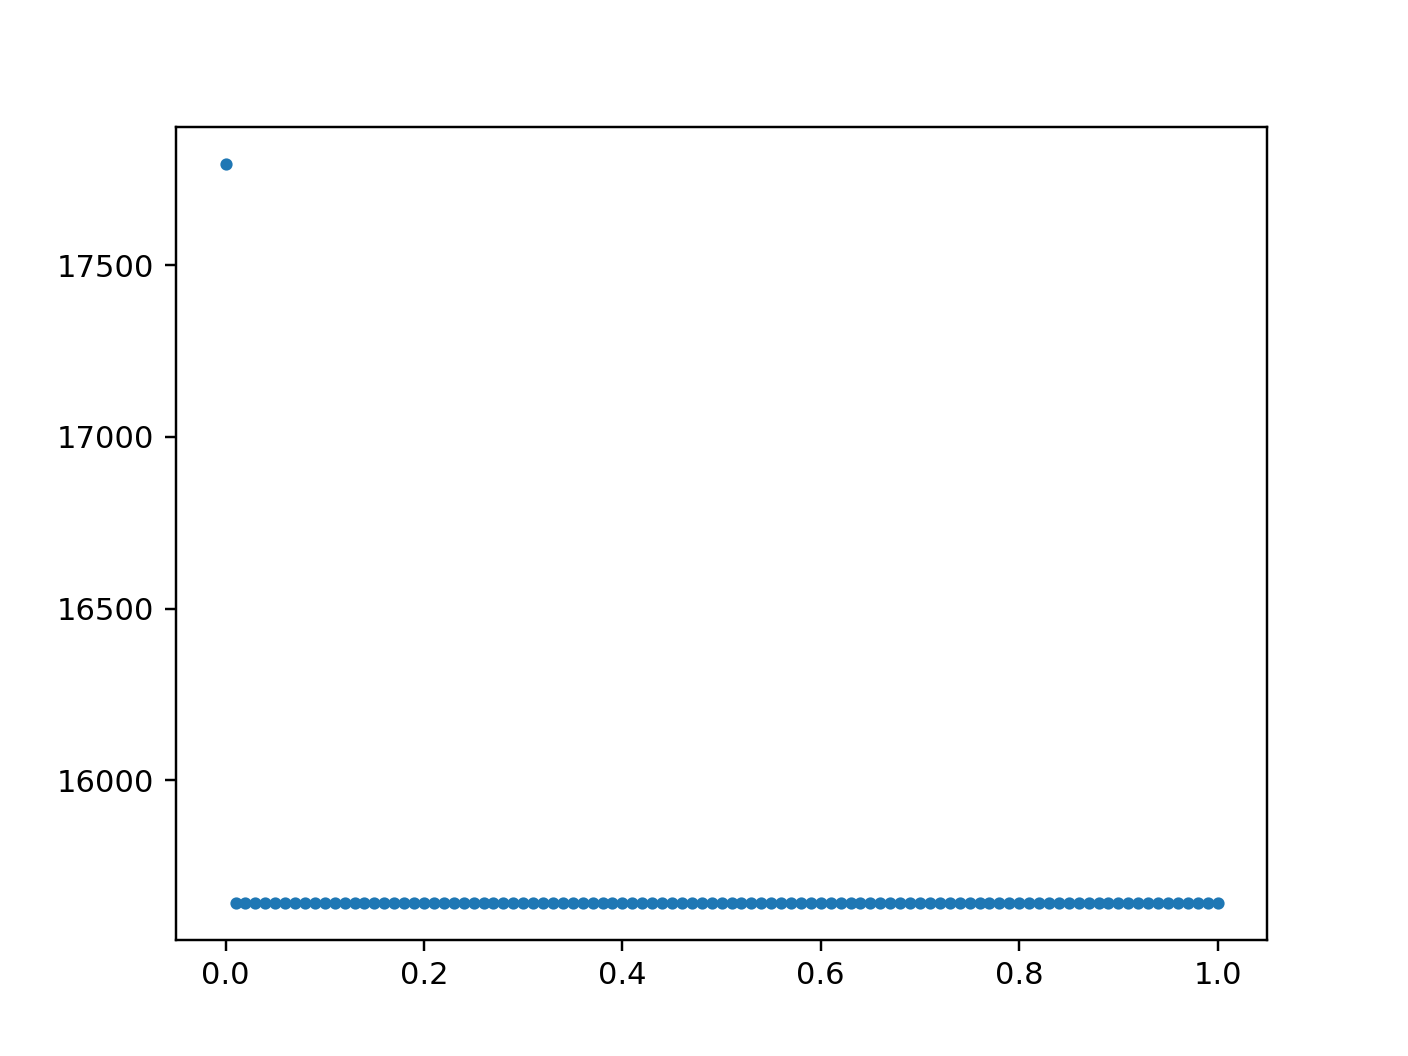

In [15]:
plt.figure()
plt.plot(tt,Et,'.')

In [16]:
dEdw

array([-2.47801779e-13,  3.33244543e-12,  3.41060513e-13,  4.12114787e-13,
        0.00000000e+00,  2.84217094e-13, -5.68434189e-14,  3.46389584e-13,
        1.90425453e-12, -3.69482223e-13,  7.95807864e-13,  9.94759830e-14,
       -1.30739863e-12, -1.70530257e-13, -1.70530257e-13])

Gradient descent rapidly converges to global minimum---seems to get there in essentially one step.

In [17]:
w

array([-0.39531551, -0.01487745, -0.03640539, -0.06124058, -0.00599055,
        0.11400548,  0.02625634, -0.0156686 ,  0.01220801,  0.02485947,
        0.0627852 ,  0.0052958 , -0.12540334, -0.03310353,  0.0238618 ])

In [18]:
print(w[1:8])
print(w[8:])

[-0.01487745 -0.03640539 -0.06124058 -0.00599055  0.11400548  0.02625634
 -0.0156686 ]
[ 0.01220801  0.02485947  0.0627852   0.0052958  -0.12540334 -0.03310353
  0.0238618 ]


Interesting: the visiting team coefficients seem to be very nearly the negatives of the home teams coefficients, i.e. ${\bf w}_{\rm vis} \approx -{\bf w}_{\rm home}$, where ${\bf w} = (w_0,{\bf w}_{\rm vis},{\bf w}_{\rm hom})$. Could try a simpler model with only 8 coefficients, where the predictors are ${\bf x}_{\rm vis}-{\bf x}_{\rm hom}$.

Given 2 average teams (${\bf x} = 0$), should be able to compute the home team win probability as $1 - \sigma(w_0)$: 

In [19]:
1-sigma(w[0])

0.5975616435282745

This is quite close to the average home team win probability of $\approx 58\%$ that I get directly from the data. So, it passes the sanity check.

Retry integration with max integration time $T = 0.005$.

In [20]:
# T = 0.005
# w,dEdw,Et,tt = logisticInt(w0,T,x,y)
# plt.figure()
# plt.plot(tt,Et,'.')
# print(dEdw)

# Analysis of model performance on training data

<IPython.core.display.Javascript object>


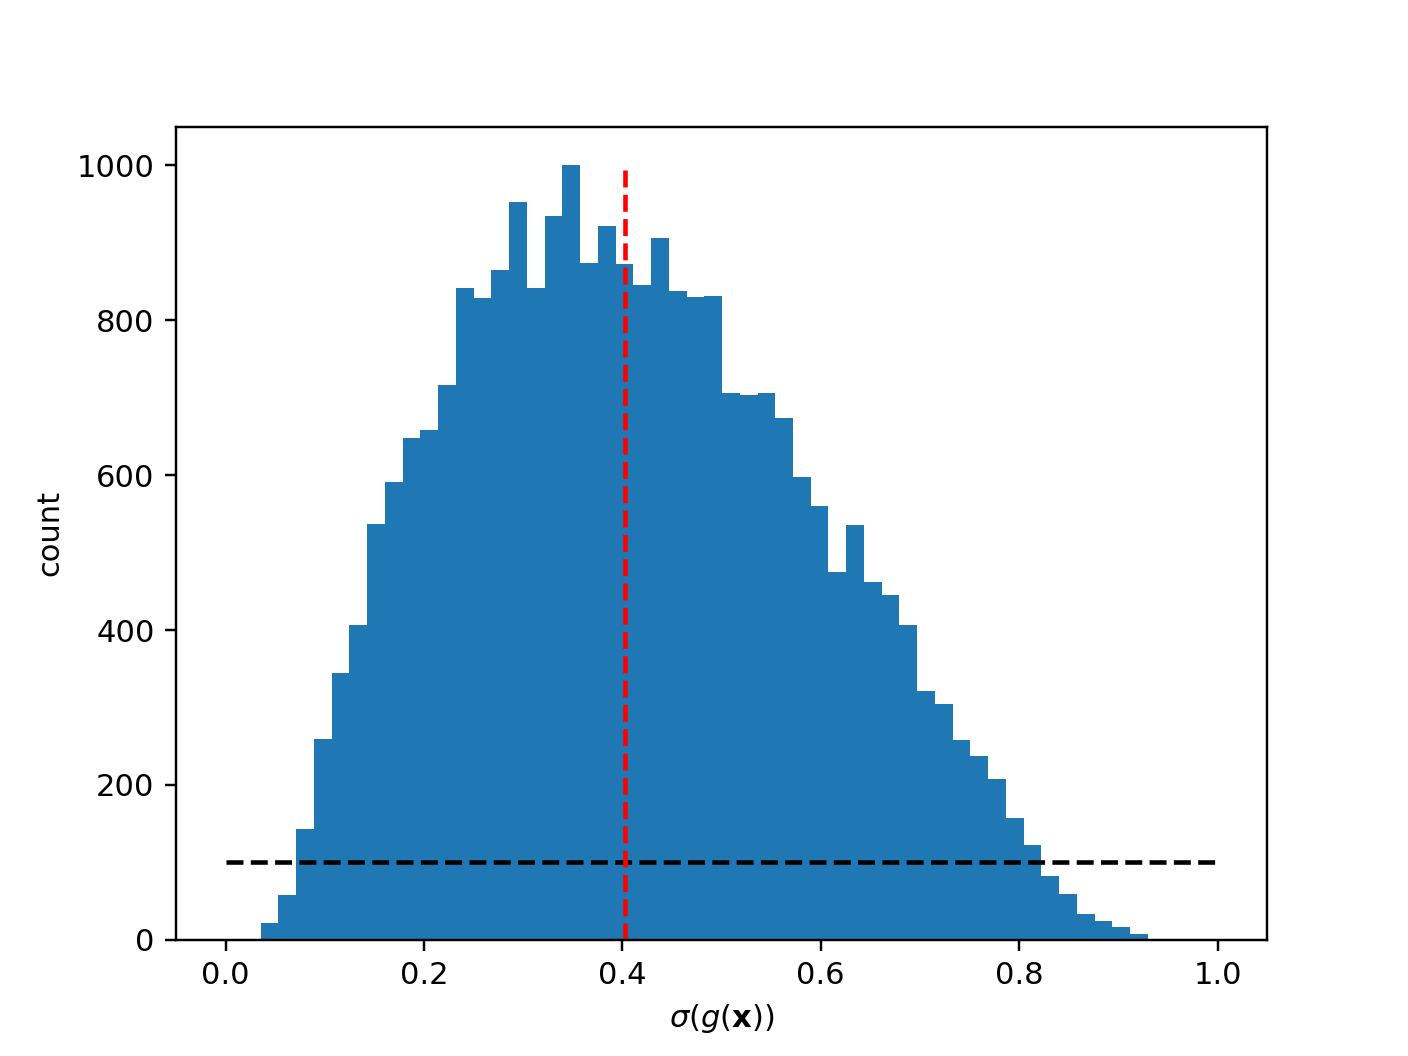

Text(0, 0.5, 'count')

In [21]:
probabilities = sigma(w @ x.T)
plt.figure()
nn,bins,patches = plt.hist(probabilities,50)
plt.plot(np.array([0,1]),np.array([100,100]),'k--') # count = 100, a cutoff for reasonable statistics
plt.plot(sigma(w[0])*np.ones((2,)),np.array([0,1000]),'r--') # avg visitor team win probability
plt.xlabel(r'$\sigma(g({\bf x}))$')
plt.ylabel('count')

In [22]:
bins[1]-bins[0]

0.017886200024372564

In [23]:
bins

array([0.03538043, 0.05326663, 0.07115283, 0.08903903, 0.10692523,
       0.12481143, 0.14269763, 0.16058383, 0.17847003, 0.19635623,
       0.21424243, 0.23212863, 0.25001483, 0.26790103, 0.28578723,
       0.30367343, 0.32155963, 0.33944583, 0.35733203, 0.37521823,
       0.39310443, 0.41099063, 0.42887683, 0.44676303, 0.46464923,
       0.48253543, 0.50042163, 0.51830783, 0.53619403, 0.55408023,
       0.57196643, 0.58985263, 0.60773883, 0.62562503, 0.64351123,
       0.66139743, 0.67928363, 0.69716983, 0.71505603, 0.73294223,
       0.75082843, 0.76871463, 0.78660083, 0.80448703, 0.82237323,
       0.84025943, 0.85814563, 0.87603183, 0.89391803, 0.91180423,
       0.92969043])

In [24]:
nn

array([  22.,   58.,  143.,  259.,  344.,  406.,  537.,  591.,  648.,
        659.,  717.,  842.,  829.,  865.,  953.,  842.,  935., 1000.,
        874.,  922.,  873.,  846.,  906.,  838.,  830.,  832.,  706.,
        704.,  706.,  674.,  598.,  560.,  475.,  536.,  462.,  445.,
        407.,  321.,  304.,  258.,  238.,  208.,  157.,  122.,   82.,
         59.,   33.,   24.,   17.,    7.])

Extract bin for each data point:

In [25]:
whichBin = np.digitize(probabilities,bins)

For each bin, calculate the actual fraction of wins in that bin:

In [26]:
actualWinProb = np.zeros((len(bins)-1,))
for i in range(1,len(bins)):
    thisBin = whichBin == i
    nGames = np.sum(thisBin)
    actualWinProb[i-1] = np.sum(y[thisBin])/nGames

Plot the result:

<IPython.core.display.Javascript object>


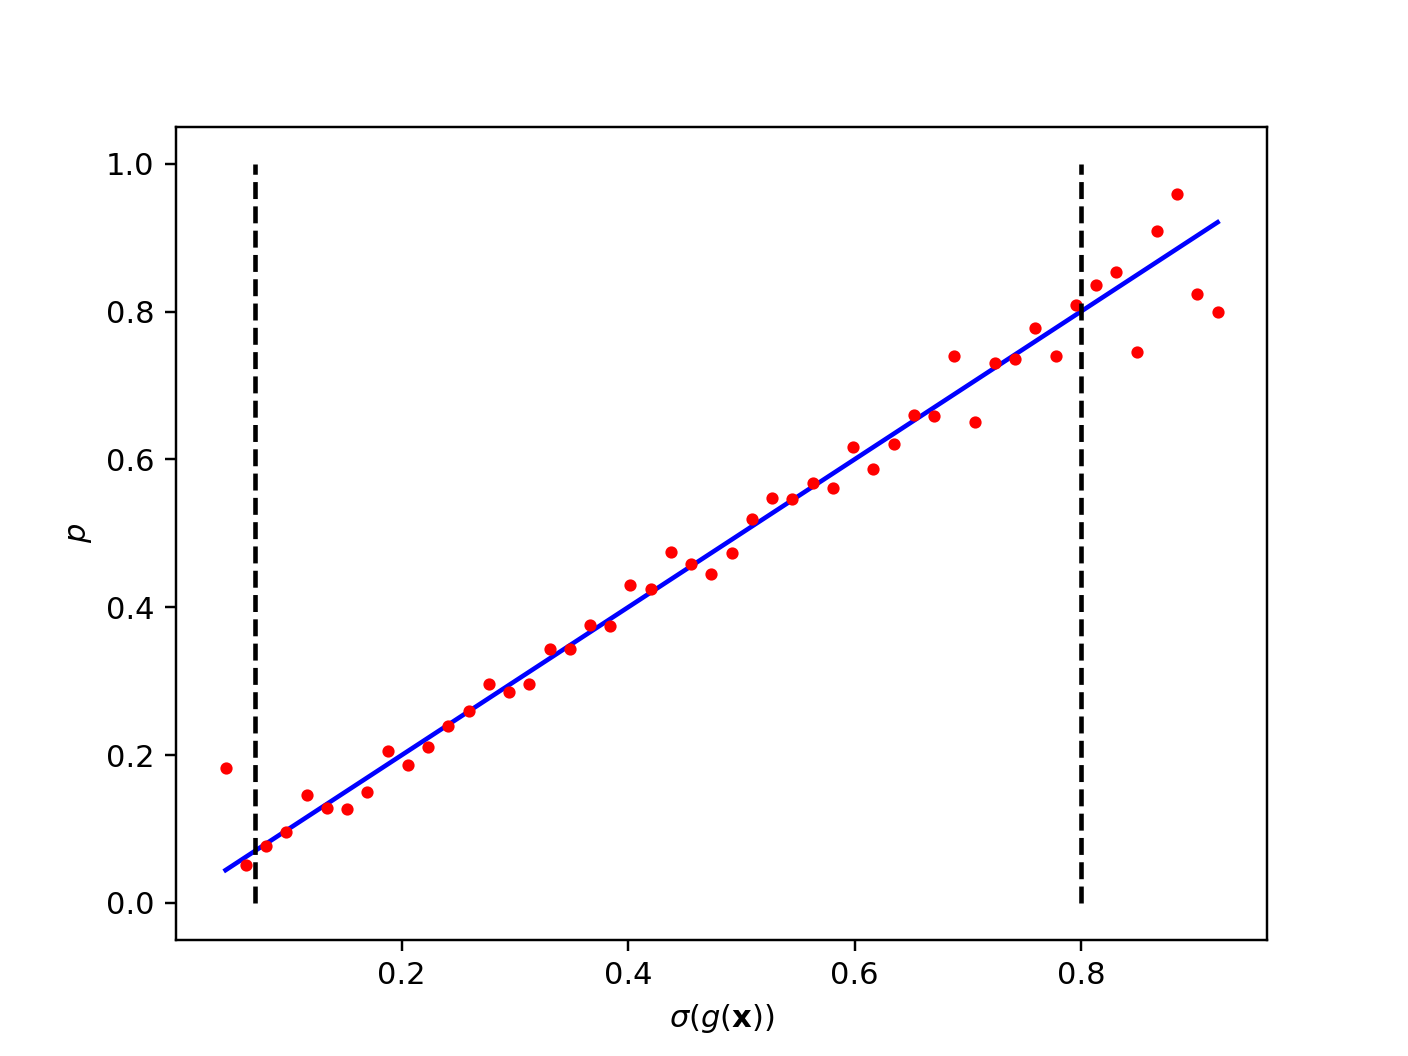

Text(0, 0.5, '$p$')

In [27]:
centeredProb = 0.5*(bins[:-1]+bins[1:])
plt.figure()
plt.plot(centeredProb,centeredProb,'b')
plt.plot(centeredProb,actualWinProb,'r.')
# boundaries of high-data range
plt.plot(0.07*np.ones((2,1)),[0,1],'k--')
plt.plot(0.8*np.ones((2,1)),[0,1],'k--')
plt.xlabel(r'$\sigma(g({\bf x}))$')
plt.ylabel(r'$p$')

# Testing

Extract test data.

In [28]:
dataset = loadGameData(2021,2021)

Dowloading 2021 season data...
##################################


In [29]:
dataset

,Season,Visitor/Neutral,Home/Neutral,VisitorWin
0,2020-21,GSW,BRK,False
1,2020-21,LAC,LAL,True
2,2020-21,CHO,CLE,False
3,2020-21,NYK,IND,False
4,2020-21,MIA,ORL,False
...,...,...,...,...
3,2020-21,MIL,PHO,False
4,2020-21,PHO,MIL,False
5,2020-21,PHO,MIL,False
6,2020-21,MIL,PHO,True


In [30]:
testData = generateInputOutputData(statMean,topV,dataset,'pyData/regSeasonData.h5')

Convert data to $({\bf x}_n,y_n)$.

In [31]:
nT = testData.shape[0] # # of data points
xT = np.hstack([np.ones((nT,1)),testData[:,:-1]]) # training data
yT = testData[:,-1] # outcomes

Compare predicted win probabilities with observed outcomes.

<IPython.core.display.Javascript object>


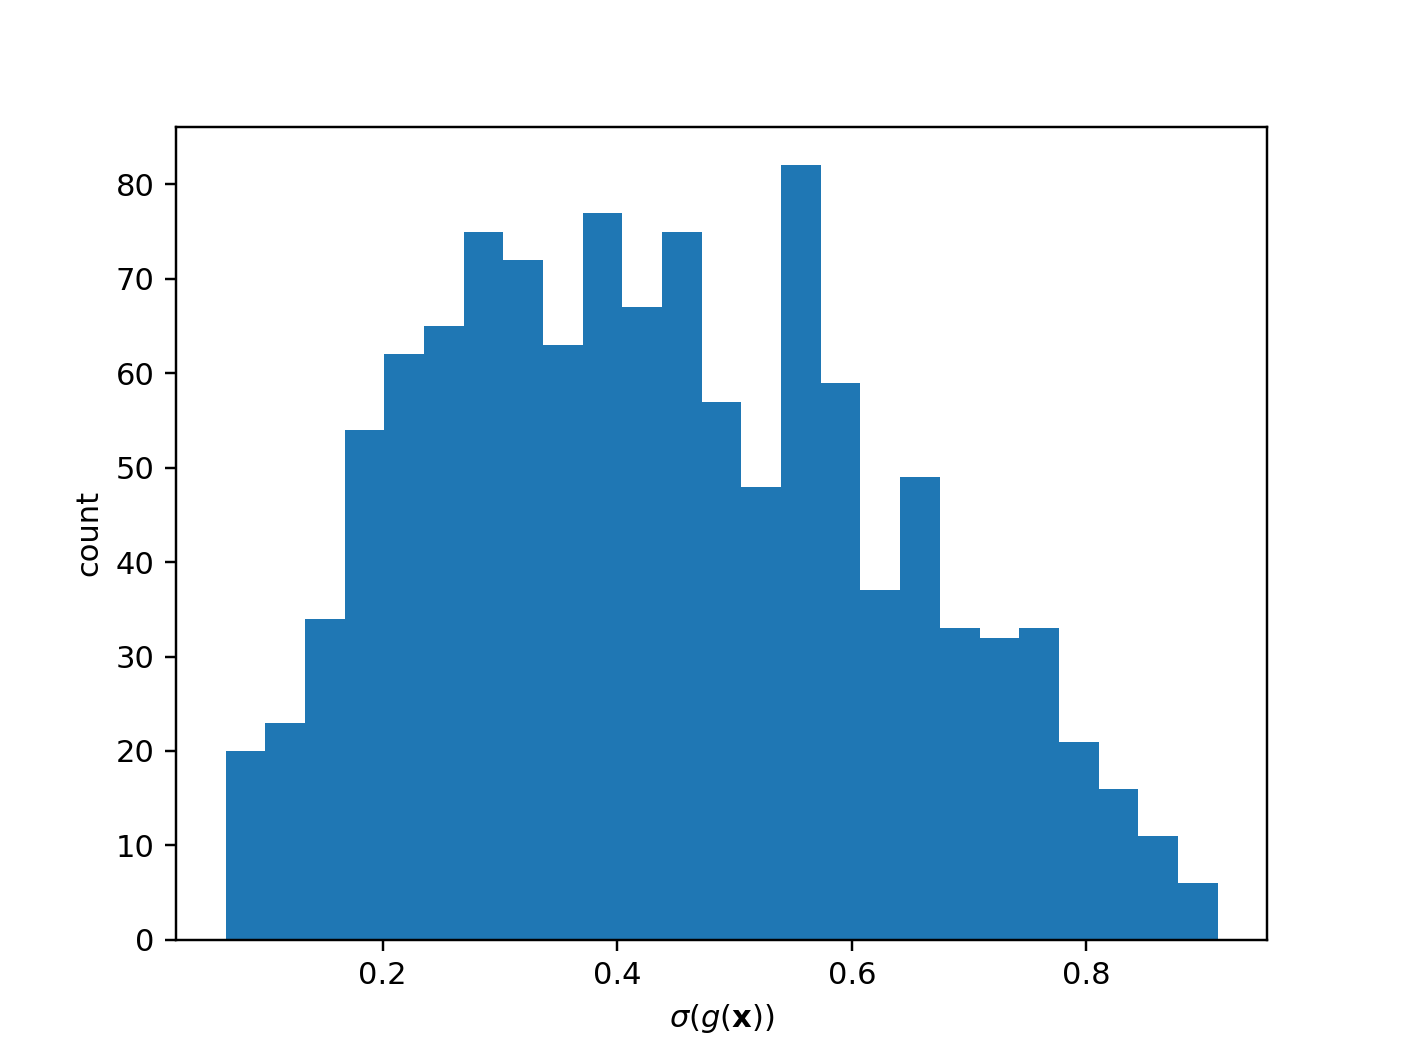

p bin size =  0.033820509883742564


In [32]:
probabilities = sigma(w @ xT.T) # predicted probabilities
plt.figure()
nn,bins,patches = plt.hist(probabilities,25)
# plt.plot(np.array([0,1]),np.array([100,100]),'k--') # count = 100, a cutoff for reasonable statistics
# plt.plot(sigma(w[0])*np.ones((2,)),np.array([0,1000]),'r--') # avg visitor team win probability
plt.xlabel(r'$\sigma(g({\bf x}))$')
plt.ylabel('count')
print('p bin size = ',bins[1]-bins[0])

<IPython.core.display.Javascript object>


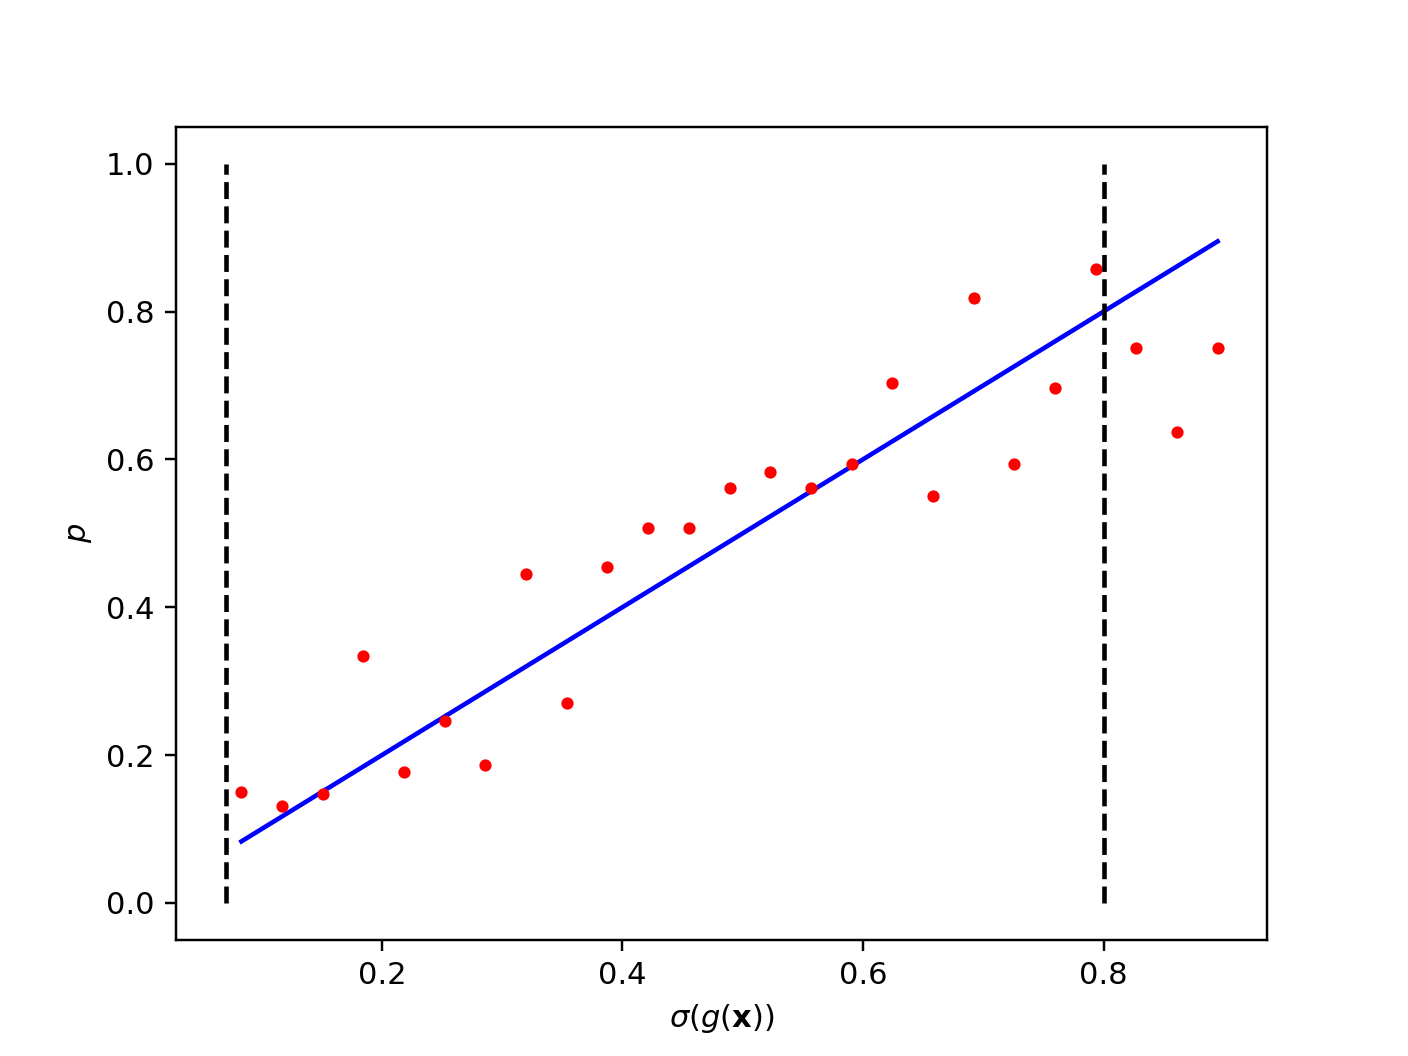

Text(0, 0.5, '$p$')

In [33]:
# discretize bin data
whichBin = np.digitize(probabilities,bins)
# for each bin, calculate actual win probabilities in that bin
actualWinProb = np.zeros((len(bins)-1,))
for i in range(1,len(bins)):
    thisBin = whichBin == i
    nGames = np.sum(thisBin)
    actualWinProb[i-1] = np.sum(yT[thisBin])/nGames
# plot result
centeredProb = 0.5*(bins[:-1]+bins[1:])
plt.figure()
plt.plot(centeredProb,centeredProb,'b')
plt.plot(centeredProb,actualWinProb,'r.')
# boundaries of high-data range
plt.plot(0.07*np.ones((2,1)),[0,1],'k--')
plt.plot(0.8*np.ones((2,1)),[0,1],'k--')
plt.xlabel(r'$\sigma(g({\bf x}))$')
plt.ylabel(r'$p$')

# Analysis of performance on testing data

Need to evaluate whether the deviations from expected values are due to chance or bad performance of model. Potentially, a $\chi^2$ test would be useful here. But let's try another approach. For each probability bin $p_i$,  binomial distribution gives the probability of each outcome. I can construct a 95% confidence interval as a the range of outcomes which account for 95% of the probability by iteratively discarding each least probable outcome until the remaining probability is $\leq$ 95%.

In [34]:
from scipy.special import comb
def binomialConfInt(p,n):
    '''
    Given a bernoulli trial success rate p and n trials, binomialConfInt computes the range of outcomes (i.e.
    # of successes) that account for 95% of the probability. Iteratively drops each least likely outcome until 
    the remaining probability is less than or equal to 95%.
    Returns the bounds of the confidence interval (pl,pr) as fractions of trials which are successes,
    and ptot, the total probability accounted for by those outcomes
    '''
    probabilities = np.zeros((n+1,))
    outcomes = list(range(n+1))
    # calculate probability of each outcome
    for i in outcomes:
        probabilities[i] = comb(n,i,exact=True) * p**i * (1-p)**(n-i)
    # iteratively remove smallest extreme probabilities until only 95% is left
    removed = 0.
    probabilities = list(probabilities)
    while removed < 0.05:
        if probabilities[0] < probabilities[-1]:
            removed += probabilities.pop(0)
            outcomes.pop(0)
        else:
            removed += probabilities.pop()
            outcomes.pop()
    # bounds on fraction of successes
    pl = outcomes[0]/n
    pr = outcomes[-1]/n
    ptot = sum(probabilities)
    
    return pl,pr,ptot
            

In [35]:
binomialConfInt(0.5,50)

(0.38, 0.62, 0.9350913529277278)

Remake the previous plot with error bars indicating the 95% confidence interval for each bin.

<IPython.core.display.Javascript object>


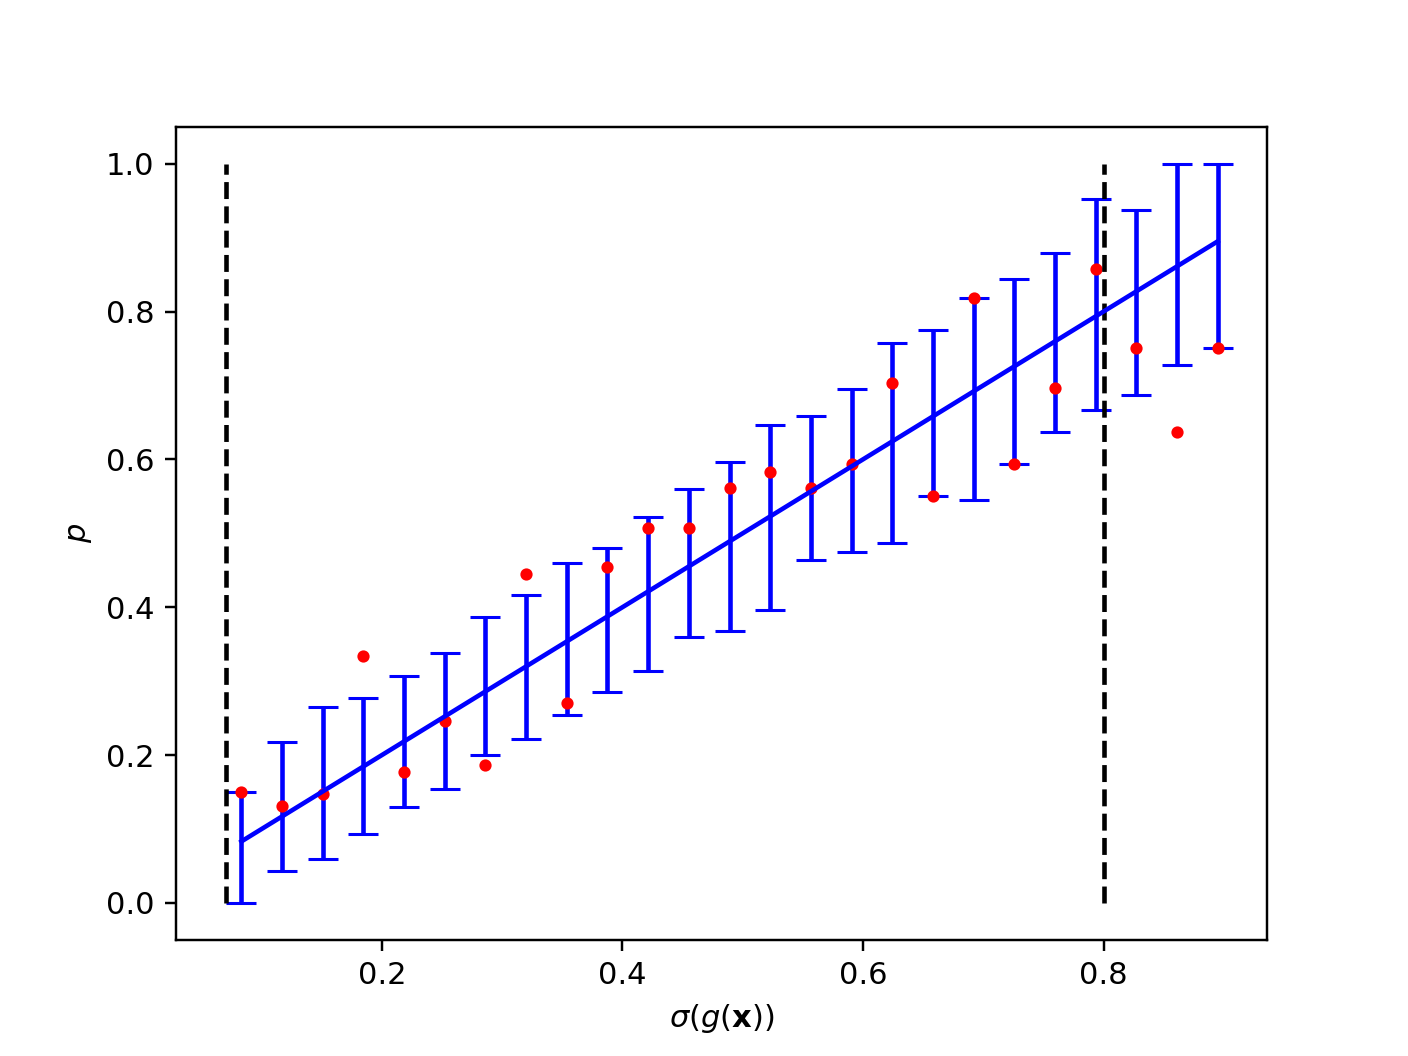

Text(0, 0.5, '$p$')

In [36]:
# discretize bin data
whichBin = np.digitize(probabilities,bins)
# for each bin, calculate actual win probabilities in that bin
actualWinProb = np.zeros((len(bins)-1,))
confInt = np.zeros((2,len(bins)-1))
for i in range(1,len(bins)):
    thisBin = whichBin == i
    nGames = np.sum(thisBin)
    actualWinProb[i-1] = np.sum(yT[thisBin])/nGames
    # calculate confidence interval
    p = 0.5*(bins[i-1]+bins[i])
    pl,pr,ptot = binomialConfInt(p,nGames)
    confInt[0,i-1] = p - pl
    confInt[1,i-1] = pr - p
# plot result
centeredProb = 0.5*(bins[:-1]+bins[1:])
plt.figure()
plt.errorbar(centeredProb,centeredProb,yerr=confInt,fmt='b',capsize=5)
plt.plot(centeredProb,actualWinProb,'r.')
# boundaries of high-data range
plt.plot(0.07*np.ones((2,1)),[0,1],'k--')
plt.plot(0.8*np.ones((2,1)),[0,1],'k--')
plt.xlabel(r'$\sigma(g({\bf x}))$')
plt.ylabel(r'$p$')

These results are very encouraging. Neglecting the data points with $p_i > 0.8$, for which there was less data to begin with, there are 23 data points, so the observed data should fall outside of the confidence intervals 1.15 times. Since my procedure for selecting the confidence intervals usually contains $< 95\%$ of the total probability, I will only count those data points as fully outside the interval as outside, and there are 3 of these in the dataset---around $0.18$, $0.29$, and $0.32$. So, definitely more than I would expect if the model was bang on, but still not too bad---definitely the model has some predicitive power. Perhaps $\chi^2$ test or some other statistical tests can provide some quantitative measurements of this.

Can also check the accuracy of the predictions using the Brier score, $$B = \frac{1}{N}\Sigma_{i=1}^N [\sigma(g({\bf x}_i)) - y_i]^2.$$ $B$ takes values between $0$ (perfect forecast) and $1$ (completely failed forecast).


In [37]:
brier = np.sum((probabilities - yT)**2)/nT
brier

0.2174738258146074

Another measure of accuracy: suppose we take our model output $\sigma(g({\bf x}))$ and attempt to predict the winner as $\lfloor 2 \sigma(g({\bf x}))\rfloor$ (i.e. 0 if predicted probability is $< 0.5$ and 1 if predicted probability is $> 0.5$). How often do we accurately pick the winner in that case?

In [38]:
pickAcc = np.sum(1 - np.abs(np.floor(2*probabilities)-yT))/nT
pickAcc

0.6490179333902647

Using this rule, the model accurately picks the winner $64.9\%$ of the time. This seems pretty good---the question is  this compares to the same rule using the odds available at sports books? And the other question is, the regular season season average data is not available until the end of the regular season. If one is trying to make forecasts on games during the regular season, how accurate are the forecasts when one uses the teams' season average stats up to that point as a proxy for the regular season average stats as the predictor variables?

# Investigation of reduced model with stat differences as predictors

Here I will try a simpler model with only 8 coefficients, where the predictors are ${\bf x}_{\rm vis}-{\bf x}_{\rm hom}$.

In [39]:
# create new set of training data
n = trainingData.shape[0] # # of data points
x = np.hstack([np.ones((n,1)),trainingData[:,:7]-trainingData[:,7:-1]]) # training data
y = trainingData[:,-1] # outcomes
nw = x.shape[1]
nw

8

<IPython.core.display.Javascript object>


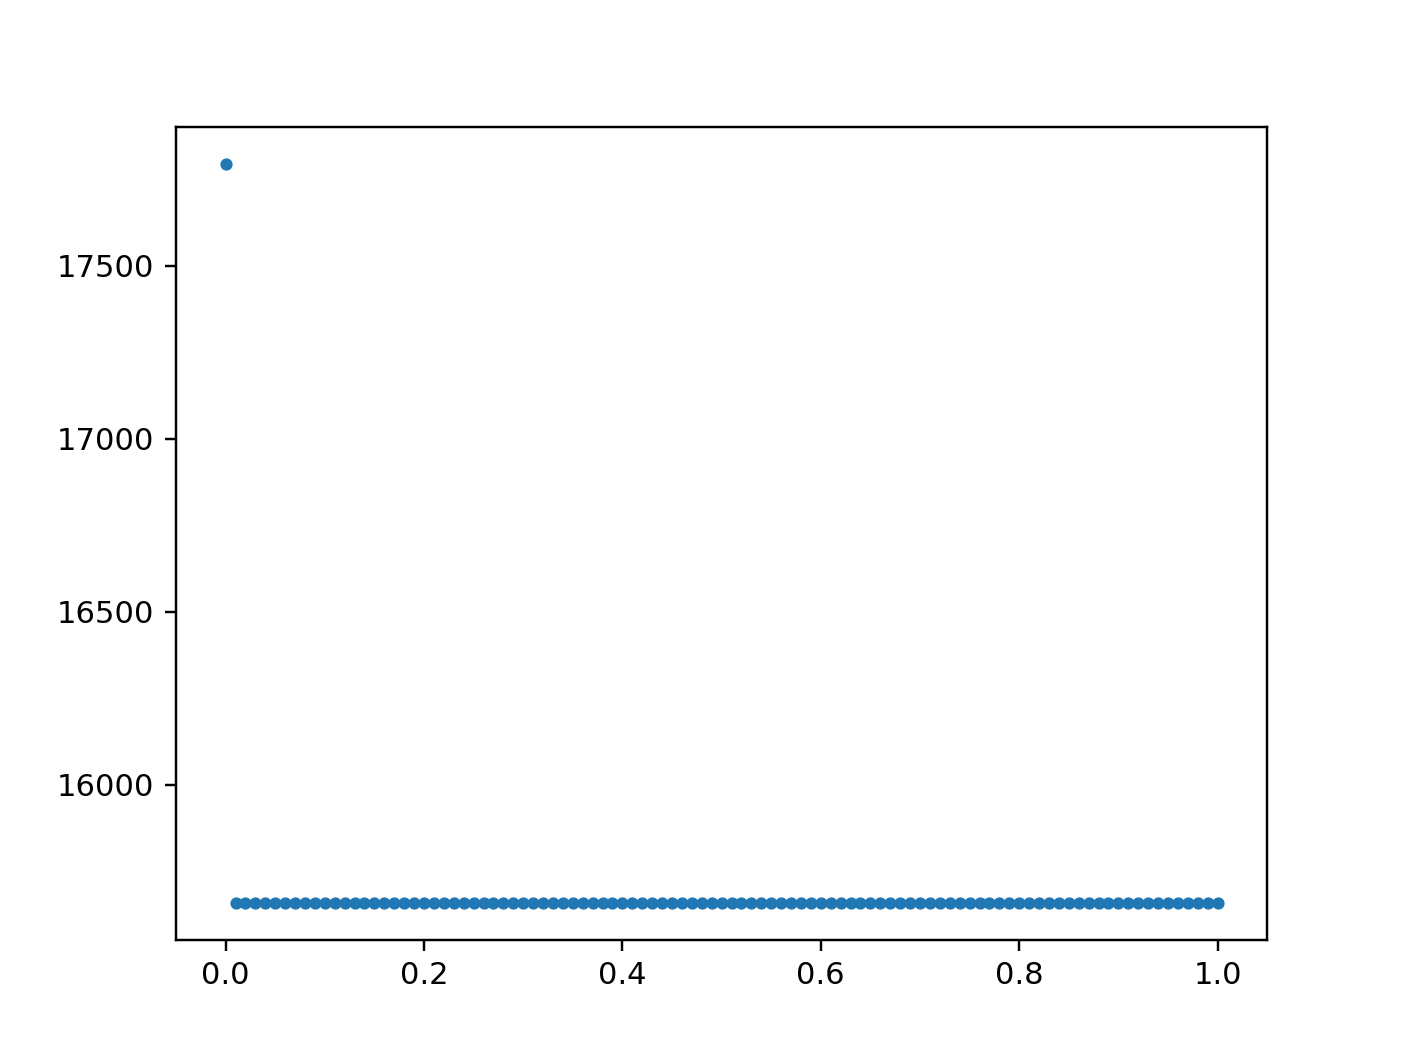

In [40]:
# train reduced model
w0 = np.zeros((nw,)) # initial condition
T = 1 # integration time

w,dEdw,Et,tt = logisticInt(w0,T,x,y) # training
# plot
plt.figure()
plt.plot(tt,Et,'.')

Analysis of reduced model performance on training data.

<IPython.core.display.Javascript object>


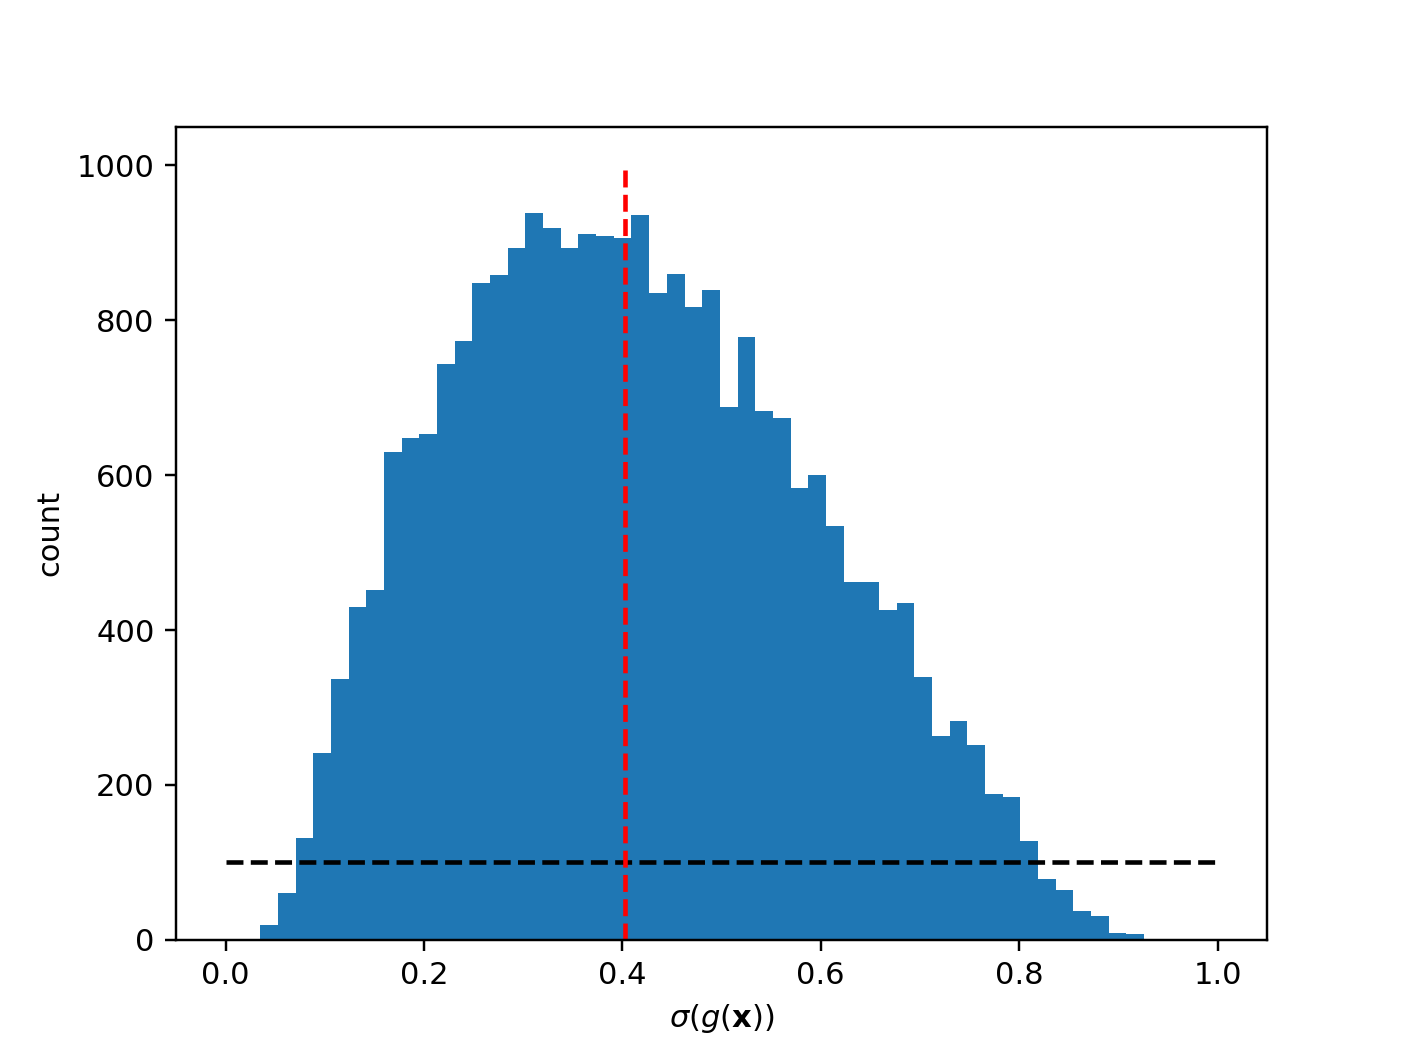

Text(0, 0.5, 'count')

In [41]:
probabilities = sigma(w @ x.T)
plt.figure()
nn,bins,patches = plt.hist(probabilities,50)
plt.plot(np.array([0,1]),np.array([100,100]),'k--') # count = 100, a cutoff for reasonable statistics
plt.plot(sigma(w[0])*np.ones((2,)),np.array([0,1000]),'r--') # avg visitor team win probability
plt.xlabel(r'$\sigma(g({\bf x}))$')
plt.ylabel('count')

In [42]:
bins[1]-bins[0]

0.017820937644667974

$p = 82\%$ and $p = 7\%$ are the cutoffs for predicted probabilities supported by a reasonable amount ($> 100$ points in a $\Delta p = 0.018$ sized bin) of data. Plot of the predicted probabilities vs. observed probabilities:

<IPython.core.display.Javascript object>


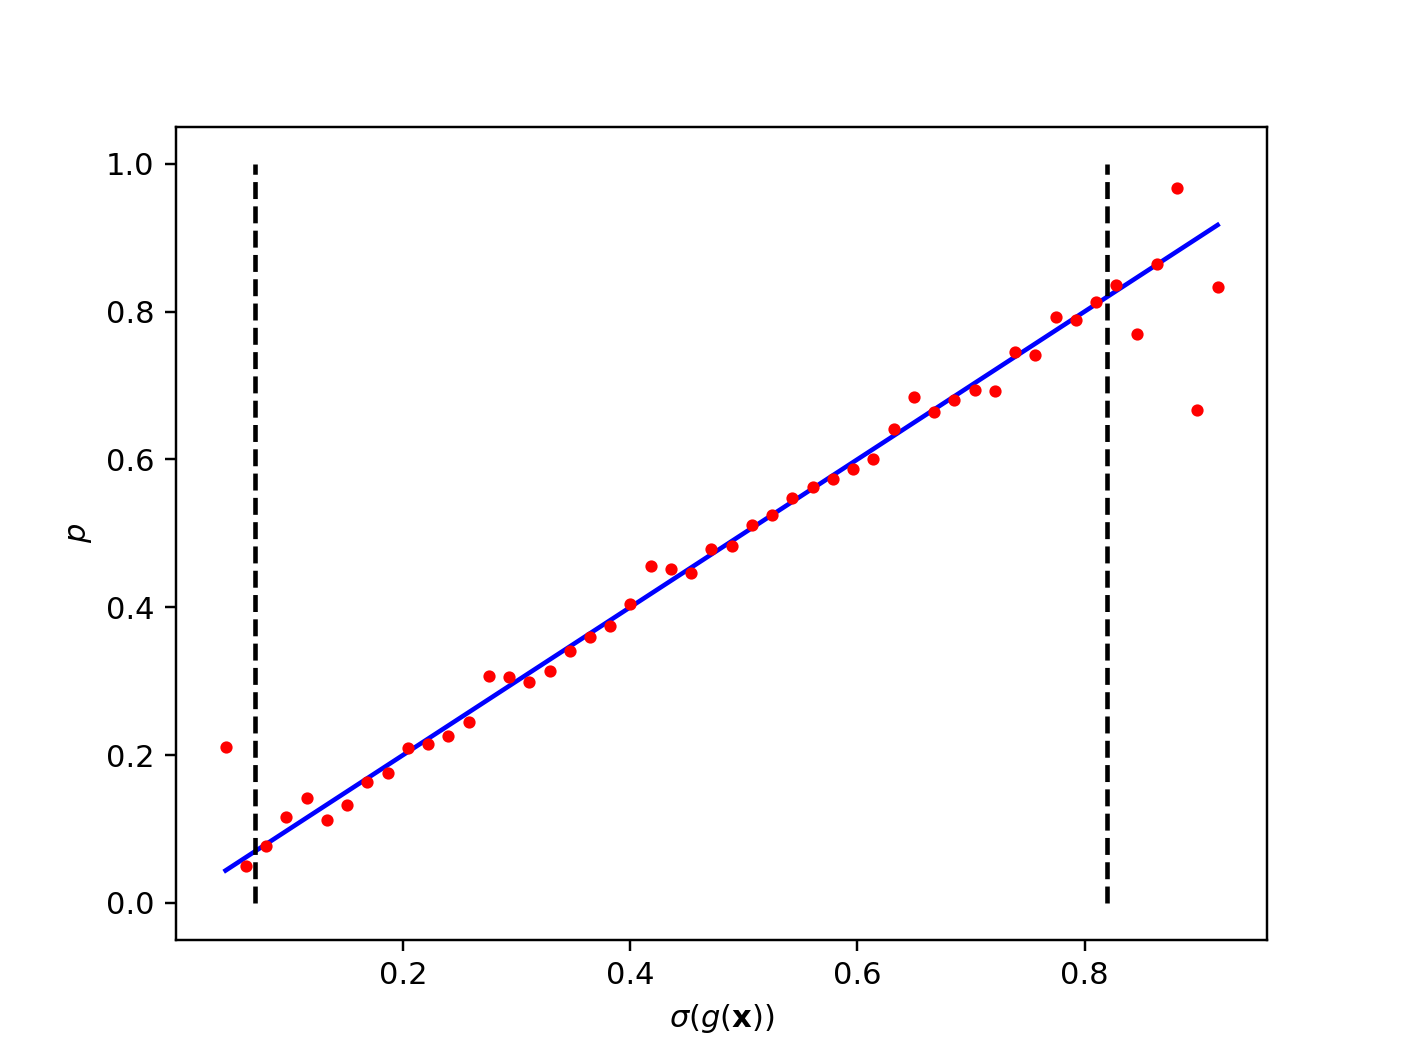

Text(0, 0.5, '$p$')

In [43]:
# discretize bin data
whichBin = np.digitize(probabilities,bins)
# for each bin, calculate actual win probabilities in that bin
actualWinProb = np.zeros((len(bins)-1,))
for i in range(1,len(bins)):
    thisBin = whichBin == i
    nGames = np.sum(thisBin)
    actualWinProb[i-1] = np.sum(y[thisBin])/nGames
# plot result
centeredProb = 0.5*(bins[:-1]+bins[1:])
plt.figure()
plt.plot(centeredProb,centeredProb,'b')
plt.plot(centeredProb,actualWinProb,'r.')
# boundaries of high-data range
plt.plot(0.07*np.ones((2,1)),[0,1],'k--')
plt.plot(0.82*np.ones((2,1)),[0,1],'k--')
plt.xlabel(r'$\sigma(g({\bf x}))$')
plt.ylabel(r'$p$')

Qualitatively, the fit to the training data looks even better than in higher variable model!

Now, let's run this model on the test data.

In [44]:
# generate test data points
nT = testData.shape[0] # # of data points
xT = np.hstack([np.ones((nT,1)),testData[:,:7]-testData[:,7:-1]]) # training data
yT = testData[:,-1] # outcomes

<IPython.core.display.Javascript object>


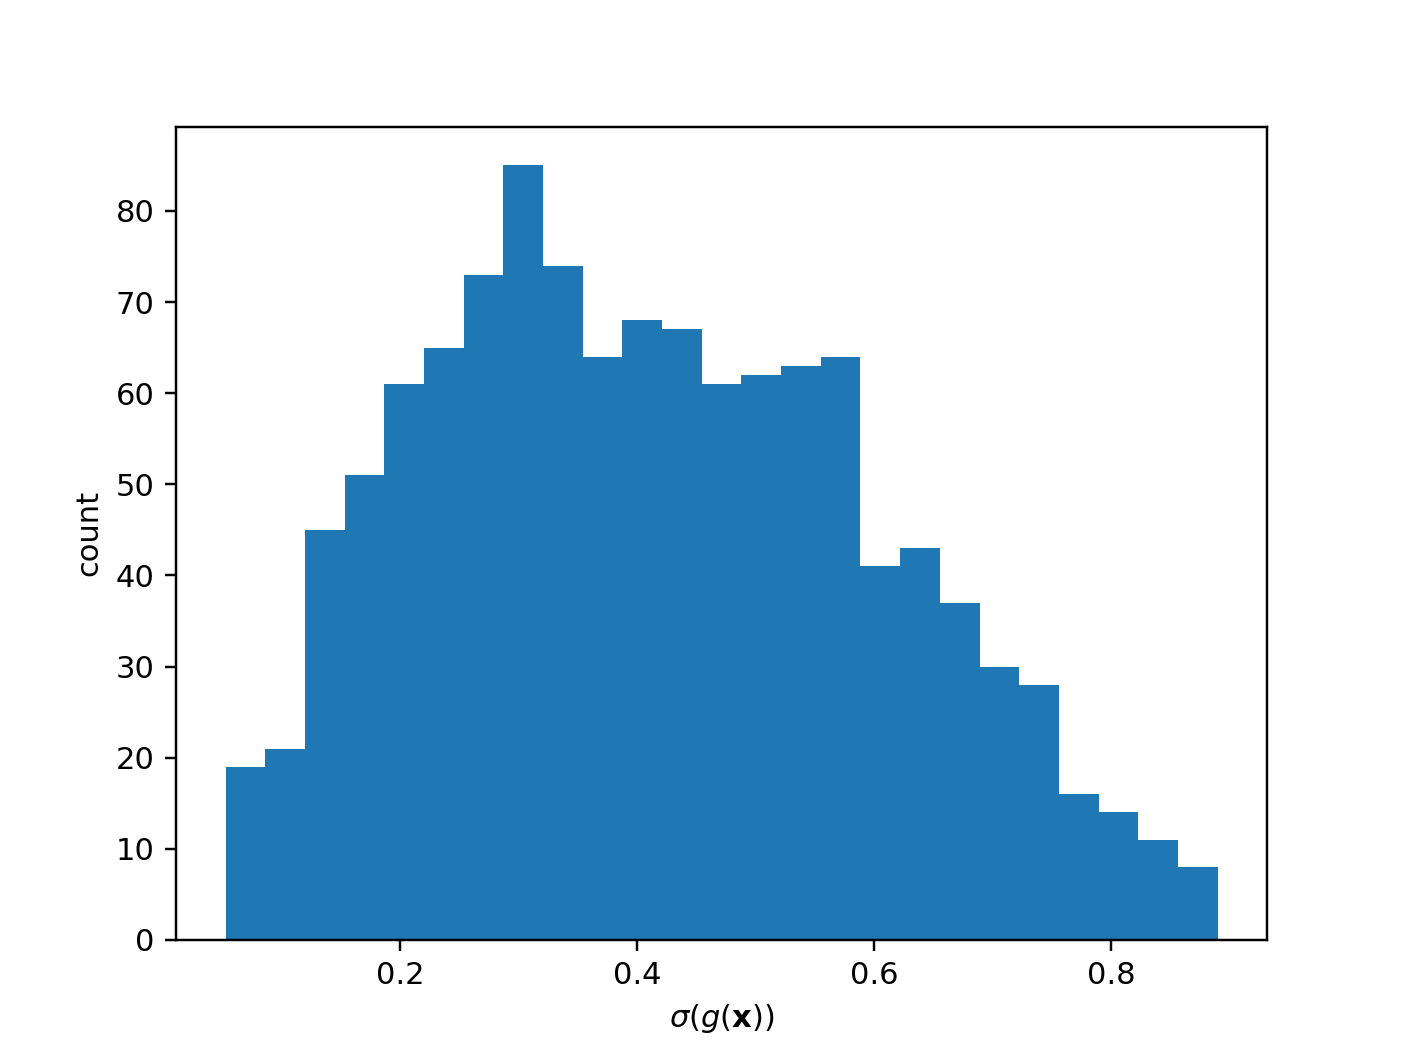

p bin size =  0.03348460123006929


In [45]:
# generate predictions on test data
probabilities = sigma(w @ xT.T) # predicted probabilities
plt.figure()
nn,bins,patches = plt.hist(probabilities,25)
# plt.plot(np.array([0,1]),np.array([100,100]),'k--') # count = 100, a cutoff for reasonable statistics
# plt.plot(sigma(w[0])*np.ones((2,)),np.array([0,1000]),'r--') # avg visitor team win probability
plt.xlabel(r'$\sigma(g({\bf x}))$')
plt.ylabel('count')
print('p bin size = ',bins[1]-bins[0])

<IPython.core.display.Javascript object>


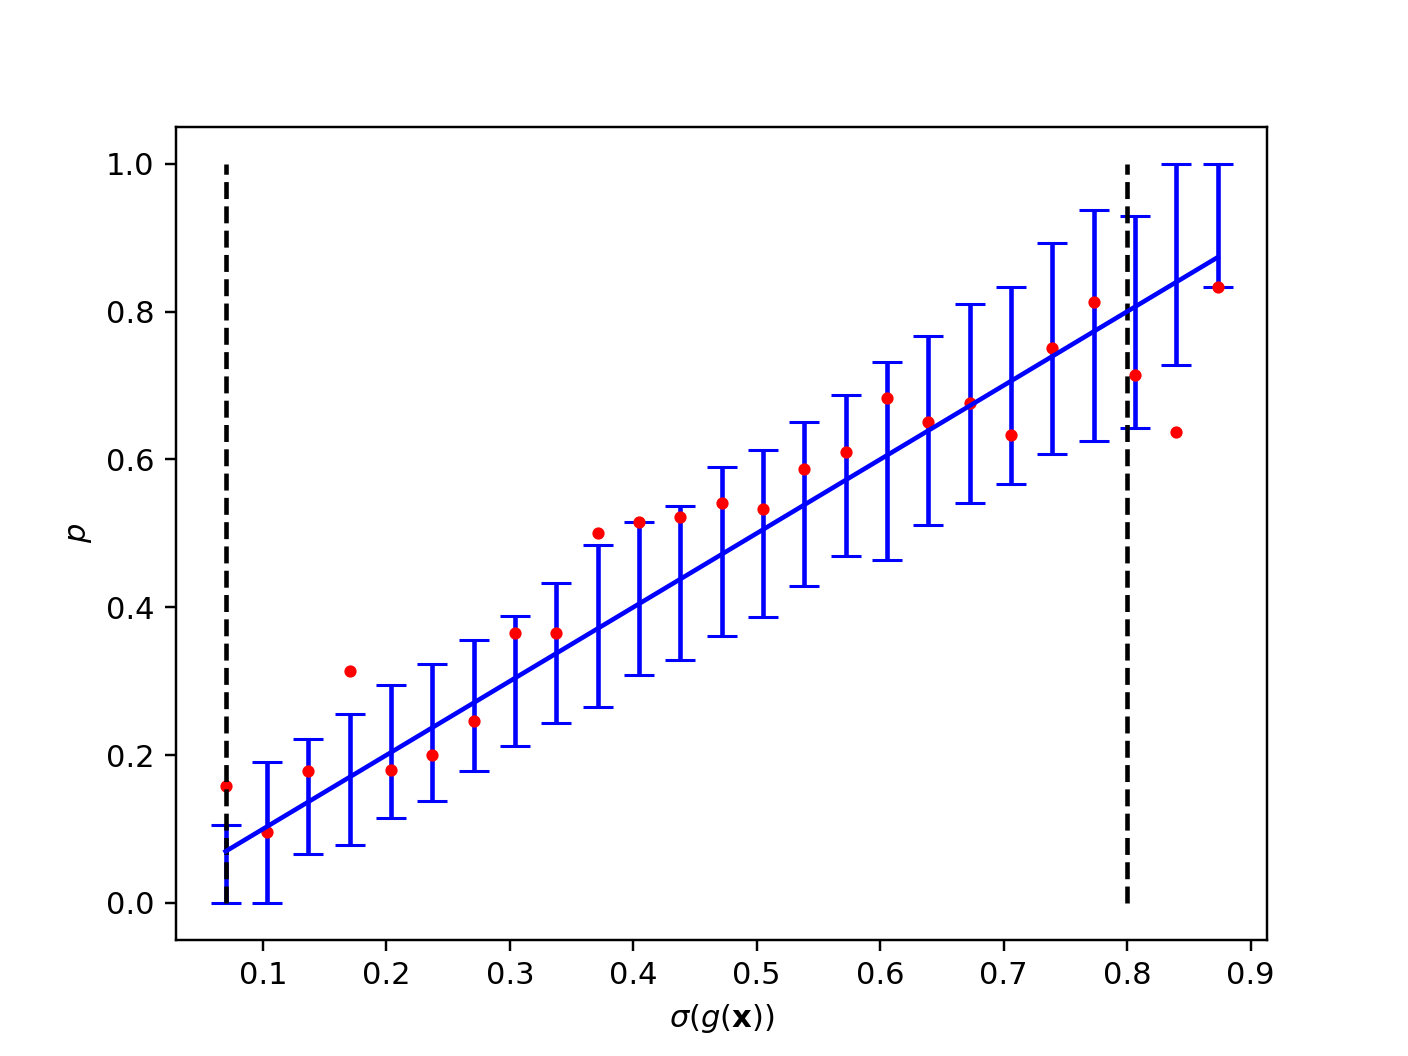

Text(0, 0.5, '$p$')

In [46]:
# plot predictions with confidence intervals
# discretize bin data
whichBin = np.digitize(probabilities,bins)
# for each bin, calculate actual win probabilities in that bin
actualWinProb = np.zeros((len(bins)-1,))
confInt = np.zeros((2,len(bins)-1))
for i in range(1,len(bins)):
    thisBin = whichBin == i
    nGames = np.sum(thisBin)
    actualWinProb[i-1] = np.sum(yT[thisBin])/nGames
    # calculate confidence interval
    p = 0.5*(bins[i-1]+bins[i])
    pl,pr,ptot = binomialConfInt(p,nGames)
    confInt[0,i-1] = p - pl
    confInt[1,i-1] = pr - p
# plot result
centeredProb = 0.5*(bins[:-1]+bins[1:])
plt.figure()
plt.errorbar(centeredProb,centeredProb,yerr=confInt,fmt='b',capsize=5)
plt.plot(centeredProb,actualWinProb,'r.')
# boundaries of high-data range
plt.plot(0.07*np.ones((2,1)),[0,1],'k--')
plt.plot(0.8*np.ones((2,1)),[0,1],'k--')
plt.xlabel(r'$\sigma(g({\bf x}))$')
plt.ylabel(r'$p$')

In [47]:
w

array([-0.39654145, -0.01357402, -0.03066232, -0.06195398, -0.00565727,
        0.11958178,  0.02957253, -0.01943792])

By the metric "how many times do the data points fall outside the confidence intervals," the performance of the reduced model on the test data is the same. Something that the reduced model seems to do more strongly than the full model is apparently underestimate the true win probability of games whose predicted probability falls in the 0.3--0.6 range. The fact that the red points fall above the blue line so much more often than below it seems like it cannot be due to chance. With the full model, it seems that true data falling above the blue line is still preferred, but less so than in the reduced model. This could be a point in favor of the full model. But could this observation be due to the skew in the distirbution of outcomes of multiple Bernoulli trials itself? Let's check this.

<IPython.core.display.Javascript object>


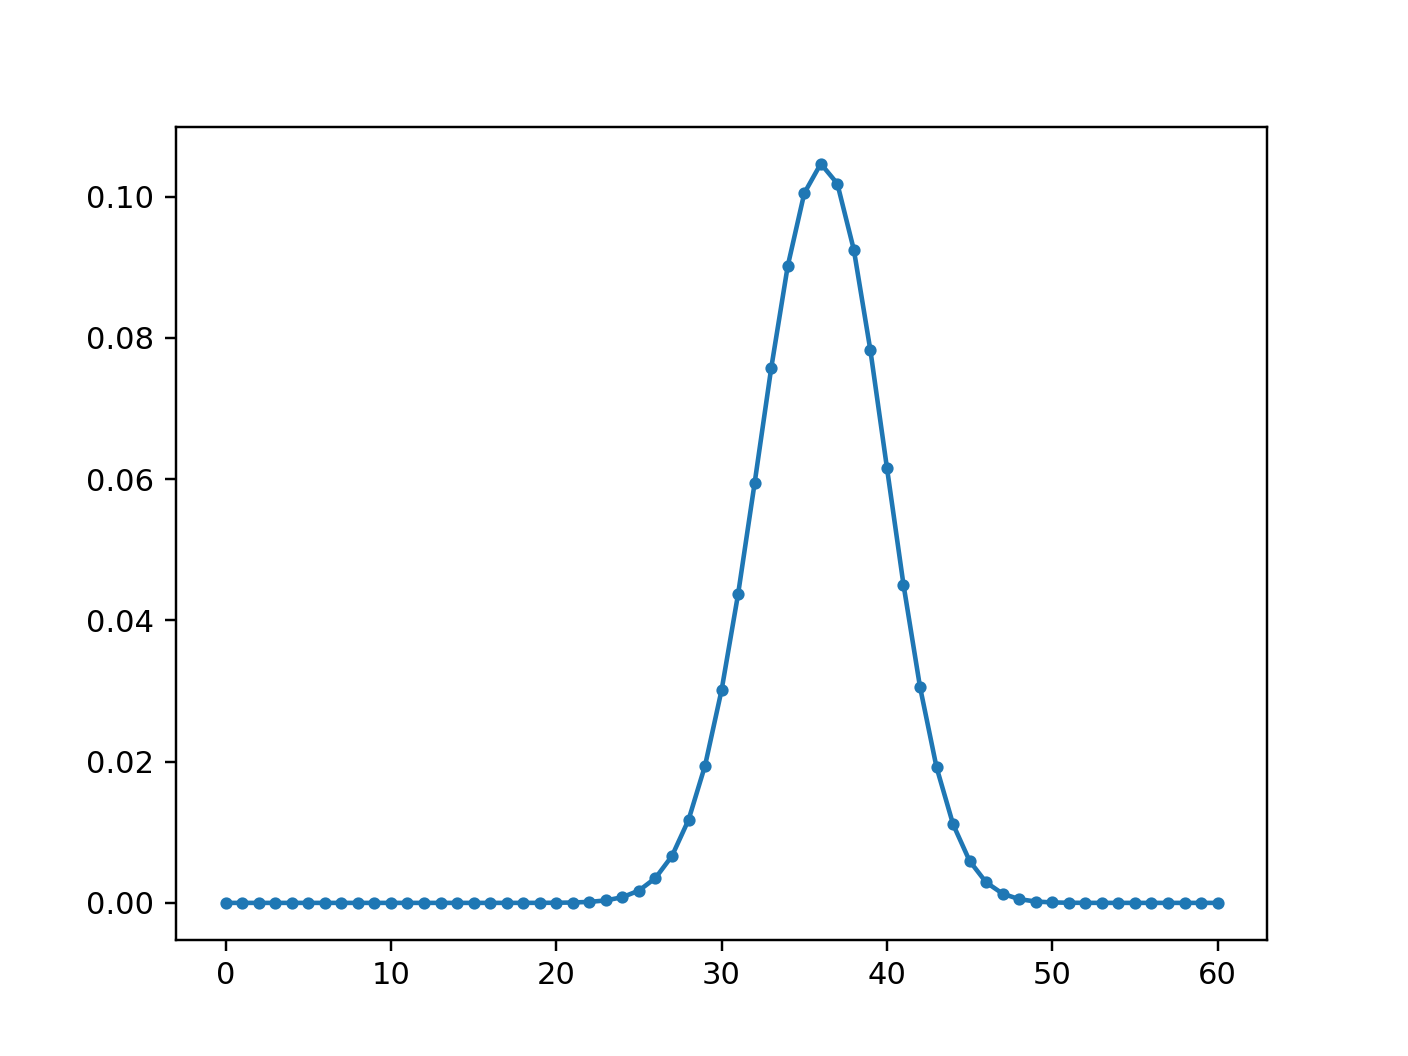

In [48]:
p = 0.6 # success probability
n = 60 # number of trials

probs = np.zeros((n+1,))
outcomes = list(range(n+1))
# calculate probability of each outcome
for i in outcomes:
    probs[i] = comb(n,i,exact=True) * p**i * (1-p)**(n-i)
    
plt.figure()
plt.plot(outcomes,probs,'.-')

For the range of predicted probabilities where I observe this behavior, the distribution of outcomes is appears approximately symmetric (for the number of trials that I typically have for data in that range). So it seems that the observed probabilities from the test data should be approximately equally likely to be above or below the predicted probabilities, if the model is accurate. This is closer to being true with the full model than it is with the reduced model, so I am more inclined to go with the full model.

Calculate the Brier score:

In [49]:
brier = np.sum((probabilities - yT)**2)/nT
brier

0.21837448971021028

Brier score is almost the same as the previous model, but then again this makes sense because these two models are so similar.

# Debugging

In [50]:
bins

array([0.05293393, 0.08641854, 0.11990314, 0.15338774, 0.18687234,
       0.22035694, 0.25384154, 0.28732614, 0.32081074, 0.35429535,
       0.38777995, 0.42126455, 0.45474915, 0.48823375, 0.52171835,
       0.55520295, 0.58868755, 0.62217215, 0.65565676, 0.68914136,
       0.72262596, 0.75611056, 0.78959516, 0.82307976, 0.85656436,
       0.89004896])

In [51]:
vals = pd.unique(whichBin)
vals.sort()
vals

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [52]:
2 // 5

0

In [53]:
rr = list(range(5))
rr.pop()

4

In [54]:
wVel(0,np.zeros((nw,)),x,y)

ValueError: operands could not be broadcast together with shapes (25674,8) (25674,) 

In [ ]:
x

In [ ]:
sigma(np.array([[0,1],[2,3]]))

In [ ]:
sigma((np.dot(x,np.zeros((nw,)))).astype(np.float32))

In [ ]:
n = trainingData.shape[0] # # of data points
x = np.hstack([np.ones((n,1)),trainingData[:,:-1]]) # training data
y = trainingData[:,-1] # outcomes


In [ ]:
nw = x.shape[1]
wVel(0,np.zeros((nw,)),x,y)

In [ ]:
teamDataDict[('2000-01','CHO')]

In [ ]:
dataDictStyle.head()

In [ ]:
dataDictStyle.loc[0,'x_a']

In [ ]:
out = dataDictStyle['x_a'].map(teamDataDict)
print(type(out))
print(out)

In [ ]:
outNP = out.to_numpy(copy=True)
np.asanyarray(outNP)

In [ ]:
outStacked = np.stack(outNP)
outStacked

In [ ]:
np.stack(out)

In [ ]:
test = np.array([np.array([1,2]), np.array([3,4])])
test

In [ ]:
out.isna().any()

In [ ]:
pd.DataFrame([dataDictStyle['x_a'].map(teamDataDict),dataDictStyle['x_b'].map(teamDataDict)])

In [ ]:
c1 = np.array([[0,1],[2,3],[4,5]])
c2 = np.array([6,7,8])
print(c1)
print(c2)